# Post-Up Performance EDA and Model
In this notebook, I will explore the relationships of different player stats and their expected value on future post-ups.  

Goals:
- Look for what stats might best predict post-up performance.
- Find the best model to make accurate predictions.

Conclusions:  
- Post-up performance is extremely difficult to predict due to small amount of players who do it.
- Passing ability (assist to turnover ratio) is the most important predictor.
- Free throw percentage and scoring with tight coverage were also important predictors.
- The year was important. This may have to do with trends in the league and/or recent player skillsets.

## 0. Importing Libraries and Data

In [103]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['POST_TOUCHES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['POST_TOUCH_EV'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_POST_TOUCH_EV']]
X = data.drop(columns='TARGET_POST_TOUCH_EV')

#### Splitting X and y into train, validate, and test sets

In [40]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'POST_TOUCH_EV')

## 2. Determine Potential Features
- Features used to calculate expected value (free throw percentage, turnovers, and shooting) are correlated with future performance.
- Some categories are likely related to being a better scorer (field goal attempts).
- Because of the small sample size and the large amount of features I need to  worry about overfitting as some categories might randomly be correlated with the target. For example, 'POST_TOUCH_FT_PCT_WEIGHTED' is a subset of weighted free throw percentage. Only weighted free throw percentage should likely be used as it gives a more complete picture of how a player shoots from the free throw line.
- There is a slight increase each year in effectiveness. I wonder if this is related to the increase value of an assist each year.

#### Finding correlated features

In [41]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [42]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [43]:
# Looking at the most correlated features with the target
corr_features

['POST_TOUCH_EV',
 'FT_PCT_WEIGHTED',
 'FT_PCT',
 'PAINT_TOUCH_FGA_PER_MIN',
 'PAINT_TOUCH_FGA_PER_MIN_WEIGHTED',
 'AST_TO',
 'PAINT_TOUCH_FGM_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGM_PER_MIN',
 'PAINT_TOUCHES_PER_MIN',
 'PAINT_TOUCHES_PER_MIN_WEIGHTED']

In [48]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_POST_TOUCH_EV'], alpha=.3)

#### Graphing correlated features

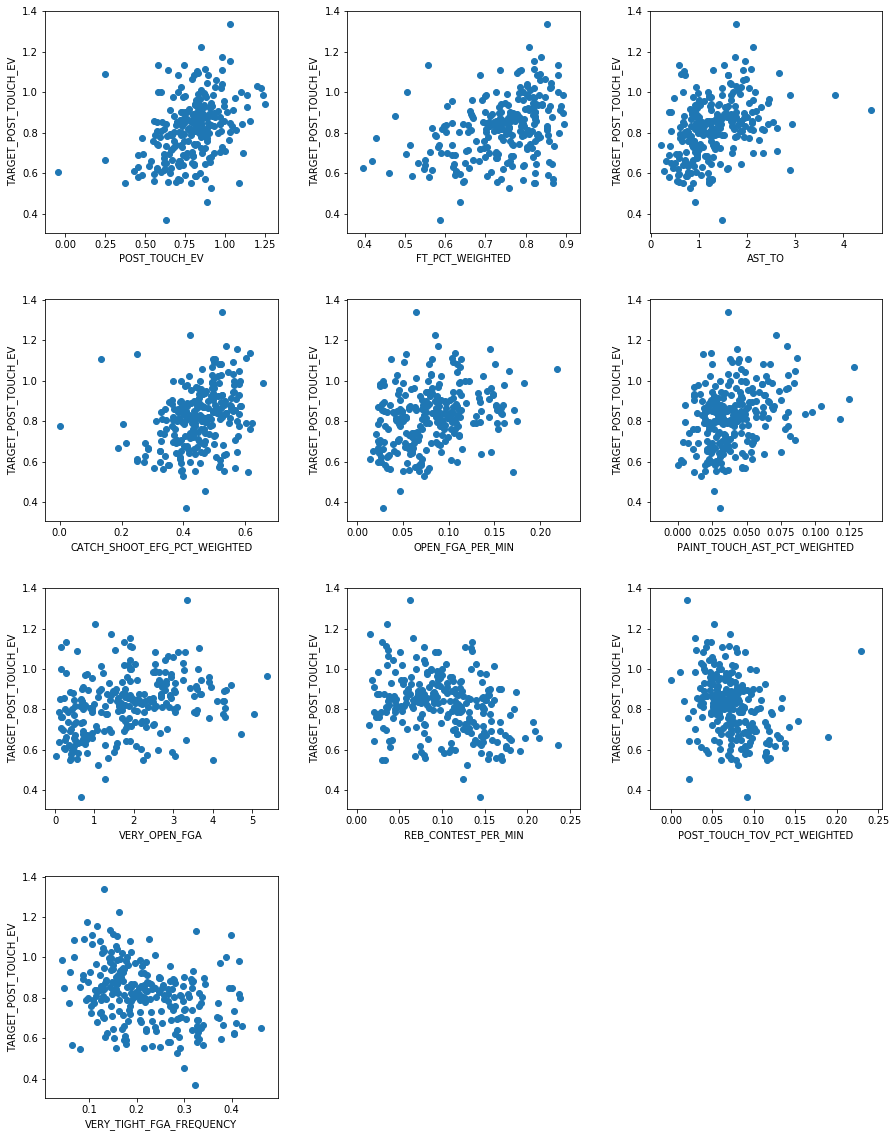

In [49]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

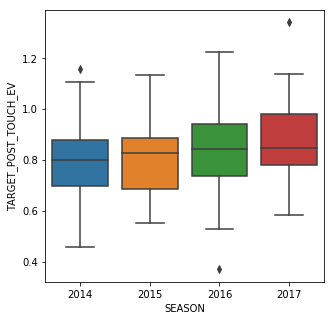

In [50]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

## 3. Modeling

#### RFECV
- Used only 1 feature...
- Did not perform very well.

In [56]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

1

In [57]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['SKINNY'], dtype='object')

In [58]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.010370807468445875

#### K BEST
- The 6 feature model seemed the best. It had a lower variance in the cross validation, high cross validation scores, and it had one of the best scores with the validation set.
- There is a slight tendency for lower than average predicted scores to be too low and higher than average predicted scores to be too high.

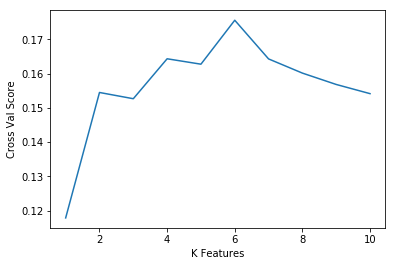

In [51]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1,11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

2  Feature Cross Val Scores:  [0.04226977 0.31165725 0.11131752 0.05017699 0.25709048]
3  Feature Cross Val Scores:  [0.03476449 0.31298649 0.11062349 0.04868494 0.25634235]
4  Feature Cross Val Scores:  [0.01543923 0.31689714 0.14758338 0.06895624 0.27282913]
5  Feature Cross Val Scores:  [0.01589138 0.31637397 0.14299229 0.06725656 0.27129558]
6  Feature Cross Val Scores:  [0.0382585  0.3267096  0.13426697 0.09719636 0.28152583]
7  Feature Cross Val Scores:  [0.03400851 0.33009776 0.13187893 0.04106104 0.28445645]
8  Feature Cross Val Scores:  [0.02401297 0.32949388 0.12440707 0.03815793 0.28472538]
9  Feature Cross Val Scores:  [0.02300059 0.32931268 0.12486421 0.03792112 0.26911329]
10  Feature Cross Val Scores:  [0.01859636 0.30368067 0.13273004 0.04459876 0.27119596]


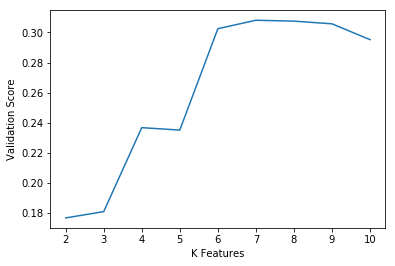

In [110]:
# Checking out 2 - 10 features
k_scores = []
for k in range(2, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(2, 11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [169]:
# Printing out the scores with 6 features
k_best = SelectKBest(f_regression, k=6)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.302518468172955

In [112]:
# Printing the model features
model_features

['AST_TO',
 'FT_PCT',
 'POST_TOUCH_EV',
 'PAINT_TOUCHES_PER_MIN',
 'PAINT_TOUCH_FGM_PER_MIN',
 'PAINT_TOUCH_FGA_PER_MIN',
 'FT_PCT_WEIGHTED',
 'PAINT_TOUCHES_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGM_PER_MIN_WEIGHTED',
 'PAINT_TOUCH_FGA_PER_MIN_WEIGHTED']

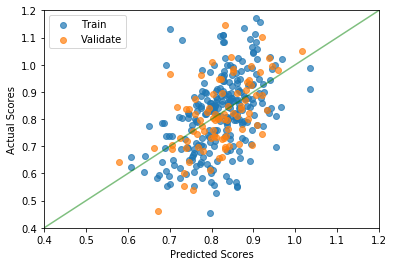

In [113]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train[model_features]), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate[model_features]), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### PCA.
- The model was had some concerning variance in the cross validation.
- 2 features seemed optimal using the elbow method.

In [232]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.29219599, 0.16988323, 0.07283906, 0.05047692, 0.04236024,
       0.03089751, 0.02747169, 0.02474043, 0.0197756 , 0.01887101,
       0.01526817, 0.01336317, 0.01176644, 0.01102176, 0.01006989])

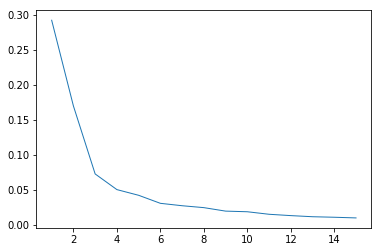

In [234]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [238]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([-0.01931818,  0.1424404 ,  0.19439541,  0.04080226,  0.14527502])

In [239]:
# Seeing the score on the validation set
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.19537917854494602

#### Neural Net
- There is a similar problem of low predictions being too high and high predictions being too low.
- The neural net was not able to do as well as Select K Best linear model was.

In [66]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [98]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [99]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [100]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

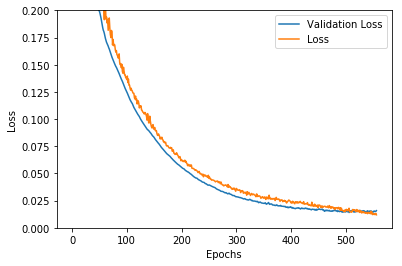

In [101]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [104]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.08607322064193434

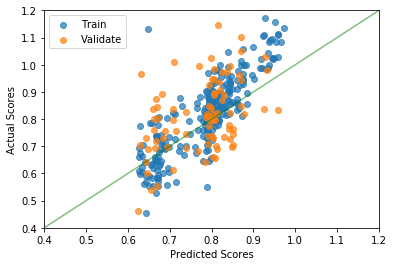

In [107]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into expected value, and features that I wanted to experiment with.
- The scores seem better than the neural net, but worse than Select K Best.
- There is the same problem of overvaluing low scores and undervaluing high scores.

In [256]:
# Saving the model features
model_features = ['OPEN_FG2_PCT_WEIGHTED', 'FT_PCT_WEIGHTED', 'POST_TOUCH_AST_PCT_WEIGHTED',
                  'POST_TOUCH_FGA_PCT', 'POST_TOUCH_TOV_PCT_WEIGHTED', 'POST_TOUCH_PTS_PCT_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015', '2016', '2017',
                  'AST_TO_WEIGHTED', 'TIGHT_FG2_PCT_WEIGHTED', 'VERY_TIGHT_FG2_PCT']

In [257]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean()

0.09405802208270497

In [258]:
# Checking the validation score
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.23809603540536387

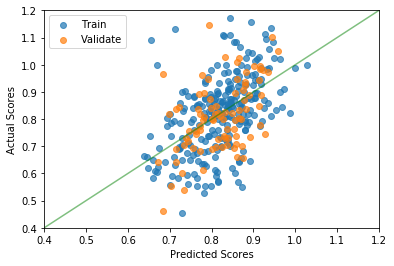

In [259]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(model.predict(X_train[model_features]), y_train, label='Train', alpha=.7)
plt.scatter(model.predict(X_validate[model_features]), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

#### Regularized Linear Regression with My Selected Features
- These scores are much improved from the linear regression.
- The ridge predictions are very narrow.
- They both suffer from having the same over and under predicting problem as the other models.
- They both really valued assist to turnover values and the year.

In [260]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [261]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.02503667, 0.26129897, 0.10250103, 0.10428096, 0.25416466])

In [262]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.259985068599364

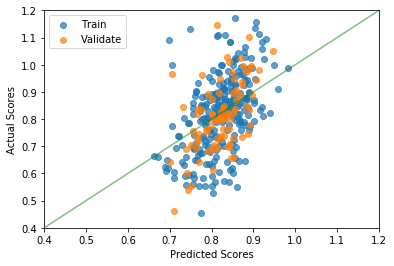

In [263]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(ridge.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(ridge.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend();

In [264]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-0.01819409,  0.2737654 ,  0.15752803,  0.06312801,  0.23234102])

In [265]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.24762105459288153

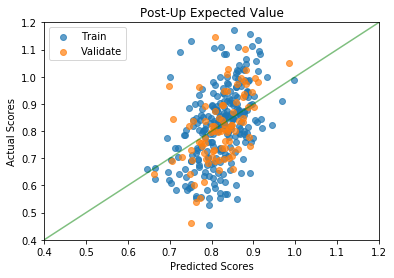

In [266]:
# Plotting the predicted versus actual scores for the training and validation sets
plt.scatter(lasso.predict(X_train_scaled), y_train, label='Train', alpha=.7)
plt.scatter(lasso.predict(X_validate_scaled), y_validate, label='Validate', alpha=.7)
plt.plot([.4,1.2], [.4,1.2], color='g', alpha=.5)
plt.xlim(.4,1.2)
plt.ylim(.4,1.2)
plt.xlabel('Predicted Scores')
plt.ylabel('Actual Scores')
plt.legend()
plt.title('Post-Up Expected Value');

In [267]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
OPEN_FG2_PCT_WEIGHTED,-0.000000,-0.003626
FT_PCT_WEIGHTED,0.031929,0.022228
POST_TOUCH_AST_PCT_WEIGHTED,0.001958,0.011472
POST_TOUCH_FGA_PCT,0.000000,0.000017
POST_TOUCH_TOV_PCT_WEIGHTED,-0.018447,-0.016473
POST_TOUCH_PTS_PCT_WEIGHTED,0.000000,0.009163
POST_TOUCH_RATE_WEIGHTED,-0.000000,-0.004282
PLAYER_HEIGHT_INCHES,-0.000000,-0.002572
SKINNY,-0.003425,-0.009456
AGE,0.000000,0.005083


#### Final scores (Lasso)
- The r2 score on the test set was reasonable compared to many of the models' cross validation scores.
- 26.1% percent improvement over baseline predictions on the test set.

In [268]:
# Lasso score on test data
X_test_scaled = scaler.transform(X_test[model_features])
lasso.score(X_test_scaled, y_test)

0.17867292481903063

In [269]:
# Root mean squared error
rmse = mean_squared_error(y_test, lasso.predict(X_test_scaled)) ** .5
rmse

0.12577776465779492

In [270]:
# The score if the prediction was just the value from the current year
baseline = mean_squared_error(y_test, X_test['POST_TOUCH_EV']) ** .5
baseline

0.1701502971787967

In [271]:
# Looking at the percent improvement
1 - rmse/baseline

0.2607843374753228

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [150]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_POST_TOUCH_EV'] = lasso.predict(X_train_scaled)

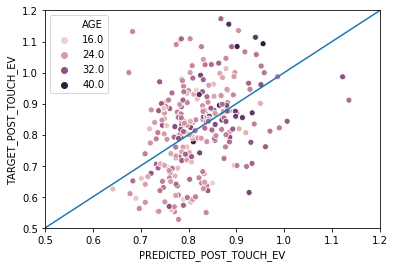

In [170]:
sns.scatterplot('PREDICTED_POST_TOUCH_EV', 'TARGET_POST_TOUCH_EV', data=train, hue='AGE')
plt.plot([0,1.2], [0,1.2])
plt.xlim(.5, 1.2)
plt.ylim(.5, 1.2);